# Generating Synthetic Wind Power Time Series

In [ ]:
import os
import re
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from typing import List, Dict, Tuple

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

from utils import tools, clean_data
import generate_wind

In [ ]:
config = tools.load_config("config.yaml")

dir = os.path.join(config['data']['raw_dir'], 'wind')
w_vert_dir = config['data']['w_vert_dir']
turbine_dir = config['data']['turbine_dir']
turbine_power = config['data']['turbine_power']
turbine_path = os.path.join(turbine_dir, turbine_power)
specs_path = config['data']['turbine_specs']
specs_path = os.path.join(turbine_dir, specs_path)
cp_path = config["data"]["turbine_cp"]
cp_path = os.path.join(turbine_dir, cp_path)

features = config['features']

params = config['wind_params']

_, wind_features = clean_data.relevant_features(features=features)

In [3]:
station_id = '00164'
file = f'Station_{station_id}.csv'
w_vert_file = f'w_vert_{station_id}.csv'

data = pd.read_csv(os.path.join(dir, file), delimiter= ",")
data['timestamp'] = pd.to_datetime(data['timestamp'], utc=True)
data.set_index('timestamp', inplace=True)
data = data.resample('1H', closed='left', label='left', origin='start').mean()
data = data[wind_features]
# get the vertical wind_speed
w_vert = pd.read_csv(os.path.join(w_vert_dir, w_vert_file), delimiter=",")
w_vert['timestamp'] = pd.to_datetime(w_vert['timestamp'], utc=True)
w_vert.set_index('timestamp', inplace=True)
w_vert = w_vert.resample('1H', closed='left', label='left', origin='start').mean()
#data = pd.merge(data, w_vert, left_index=True, right_index=True, how='inner')
data = pd.merge_asof(
    data,
    w_vert,
    left_index=True,
    right_index=True,
    direction='backward',         # wähle den letzten bekannten Wert
)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15648 entries, 2023-07-24 00:00:00+00:00 to 2025-05-05 23:00:00+00:00
Freq: H
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   wind_speed         15648 non-null  float64
 1   temperature_2m     15648 non-null  float64
 2   relative_humidity  15648 non-null  float64
 3   std_v_wind         15648 non-null  float64
 4   pressure           15648 non-null  float64
 5   wind_direction     15648 non-null  float64
 6   w_vert             15641 non-null  float64
dtypes: float64(7)
memory usage: 978.0 KB


In [5]:
power_curves, cp_curves, specs = generate_wind.get_turbines(turbine_path=turbine_path,
                                                        cp_path=cp_path,
                                                        specs_path=specs_path,
                                                        params=params)

In [6]:
turbine_nr = 3
turbine = params['turbines'][turbine_nr] # remove [[0]] for several turbines
print(f'Using turbine: {turbine}')
rotor_diameter = specs[turbine]['diameter']
hub_height = specs[turbine]['height']
cut_in = specs[turbine]['cut_in']
cut_out = specs[turbine]['cut_out']
rated_speed = specs[turbine]['rated']

Using turbine: Vestas V90


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15648 entries, 2023-07-24 00:00:00+00:00 to 2025-05-05 23:00:00+00:00
Freq: H
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   wind_speed         15648 non-null  float64
 1   temperature_2m     15648 non-null  float64
 2   relative_humidity  15648 non-null  float64
 3   std_v_wind         15648 non-null  float64
 4   pressure           15648 non-null  float64
 5   wind_direction     15648 non-null  float64
 6   w_vert             15641 non-null  float64
dtypes: float64(7)
memory usage: 978.0 KB


In [8]:
station_id = re.split(r'[_\.]', file)[-2]

print(f'Station ID: {station_id}')
#data.drop(irrelevant_features, axis=1, inplace=True)

Station ID: 00164


### Analysis of missing values

In [9]:
data.isna().sum()

wind_speed           0
temperature_2m       0
relative_humidity    0
std_v_wind           0
pressure             0
wind_direction       0
w_vert               7
dtype: int64

In [10]:
missing_per_column_per_day = data.groupby(data.index.date).apply(lambda x: x.isna().sum())
missing_per_column_per_day[(missing_per_column_per_day != 0).any(axis=1)]

,wind_speed,temperature_2m,relative_humidity,std_v_wind,pressure,wind_direction,w_vert
2024-11-21,0,0,0,0,0,0,7


In [ ]:
df = tools.knn_imputer(data=data, n_neighbors=5)

### Saturation state

Since not all vapor quantities mix with the non-condensing gas, three states must be distinguished:

- <b>Unsaturated</b>: Only the gas phase, namely the gas-vapor mixture, is present. The partial pressure of the vapor $ p_w $ is lower than the saturation vapor pressure $ p_s $. With the partial pressure of the gas $ p_g $ the total pressure can be determined with $ p = p_g + p_d $.
  
- <b>Saturated</b>: In the gas-vapor mixture the condensation begings. The partial pressure of the vapor is equal to saturation vapor pressure $ p_s = p_w $ . 
  
- <b>Over saturated</b>: There are gas and condensate phases, whereby the gas phase (the gas-vapor mixture) is saturated. The relationships of the saturated state apply to the gas phase.

### Composition of moist air

A distinction is made between absolute and relative humidity, whereby both measure the the H<sub>2</sub>O in the vapor phase.

<b>Absolute humidity</b>: Only with respect to the vapor, fog or ice fog is not considered. The absolute humidity is identical with the partial density of water vapor $ \varrho_d $:

$ \varrho_w = \frac{m_w}{V_{Mi}} = \frac{p_w}{R_{H_20}T}$, 

where 
- $ m_w $ is the mass of the water vapor,
- $ V_{Mi} $ is the volume of the gas mixture,
- $ R_{H_2O} $ is the specific gas constant for water,
- $ T $ is the temperature of the mixture.

In the saturated state $ p_s = p_d $ it is the saturation parital density $ \varrho_s $:

$ \varrho_s = \frac{p_s}{R_{H_20}T}$.

### Relative humidity $ \phi $ 
is defined as:

$ \phi = \frac{\varrho_w}{\varrho_s} = \frac{p_{w}}{p_s} $

with:
- $ \phi $: Relative humiditiy 
- $ p_w $: Partial pressure of water vapor in the air (Pa)
- $ p_s $: Saturation vapor pressure (Pa)

The saturation vapor pressure $ p_s $ is the maximal partial pressur for the water at given temperature $ T $. A higher $ p_s $ is not possible, because the additional water will condense to liquid or disublimate to solid water (ice). 

Relative humidity $ \phi $ can take numerical values in the range $ 0 \leq \phi \leq 1 $. That means:

- $ \phi = 0 $ is dry air,
- $ \phi < 1 $ is unsaturated moist air,
- $ \phi = 1 $ is saturated moist air ($ m_{kon} = 0 $)
- $ \phi = 1 $ is oversaturated moist air ($ m_{kon} > 0 $).


### Get air density from air pressure, temperature and relative humidity

Since we need the density of the air, we need to determine the pressure and gas constant values for the mixture of dry air and water vapor.

The air density is therefore dependent from the partial density of the water vapor $ \varrho_w $ and the partial density of the dry air denoted as $ \varrho_g $, where $ g $ stands for gas.

$ \rho = \varrho_g + \varrho_w = \frac{p_g}{R_gT} + \frac{p_w}{R_{H_2O}T} $

where $ R_g $ is the specific gas constant for dry air.

The specific gas constants are given with:

- $ R_g = 287.05 \frac{J}{kgK} $
- $ R_{H_2O} = 461.5 \frac{J}{kgK} $

The partial water vapor pressure is given by first calculating the saturation vapor pressure (Huang, 2018):
https://journals.ametsoc.org/view/journals/apme/57/6/jamc-d-17-0334.1.xml

$ p_s = \exp\left(34.4942 - \frac{4924.99}{t + 237.1}\right) \cdot (t + 105)^{1.57} (t > 0°C) $

$ p_s = \exp\left(43.4942 - \frac{6545.8}{t + 278}\right) \cdot (t + 868)^{-2} (t \leq 0°C) $

With the relative humidity the partial water vapor pressure can be determined:

$ p_w = \phi * p_s $

The remaining variable $ p_g $ is calculated by subtracting $ p_g $ from the air pressure $ p $:

$ p_g = p - p_w $


### Extrapolate wind speed at hub height
https://ieeexplore.ieee.org/abstract/document/8255215

There are different methods to extrapolate the wind speed at hub height in the literature.

<b>The log-linear law</b> is based on the Monin-Obukhov similarity theory, it is a physical model stating that the wind velocity at a determined height $ h_2 $ can be calculated by:

$ v_2 = v_1 \cdot \frac{\ln\left(\frac{h_2}{z_0}\right) - \psi_m\left(\frac{h_2}{L}\right)}{\ln\left(\frac{h_1}{z_0}\right) - \psi_m\left(\frac{h_1}{L}\right)} $

- $v_2$: Wind speed to be calculated at the height $h_2$ (m/s).
- $v_1$: Wind speed measured at anemometer height $h_1$ (m/s).
- $h_2$: Target height where the wind speed is to be calculated (m).
- $h_1$: Height of the anemometer where the wind speed is measured (m).
- $z_0$: Roughness length, describing the influence of surface roughness on the wind profile (m).
- $\psi_m$: Monin-Obukhov stability function, accounting for atmospheric stability.
- $L$: Monin-Obukhov length (m), representing the thermal and dynamic properties of the atmospheric boundary layer.

But in engineering studies, the log-linear law is difficult to use for estimating vertical wind profile at a wind turbine height, among others because Monin-Obukhov stability function is dependend on the temperature difference between the heights, which is often not known.

In the case of neutral stability ($ \psi_m = 0 $), the log-linear law can be simplifies to the widely used logarithmic law which depends only on $ z_0 $ and is valid near the ground over relatively flat terrain (the lower 30-50 m), but not over complex and rough terrain (Gualtieri, 2011, 2015):

$ v_2 = v_1 \cdot \frac{\ln\left(\frac{h_2}{z_0}\right)}{\ln\left(\frac{h_1}{z_0}\right)} $

<b>The power law</b> is generally used (Tizgui, 2017).

Let $ v_1 $ be the measurement of the wind speed at height $ h_1 $ and $ v_2 $ be the wind speed at height $ h_2 $:

$ \frac{v_2}{v_1} = (\frac{h_2}{h_1})^{\alpha} $

where $ \alpha $ is the Hellmann (or friction) exponent, also known as the power exponent, depending on wind speed, atmospheric stability, land features, height and surface roughness.

It is obtained empirically (Schallenberg-Rodriguez, 2013). 

It has no phyiscal basis and its validity is generally limited to the lower atmosphere (up to 150-200 m), (Gualtieri, 2015).

<b>Estimating alpha</b>

There are different methods to estimate $ \alpha $, but the most used is C. G. Justus et al. (1976):

$ \alpha = \frac{0.37 - 0.0881 \ln(v_1)}{1 - 0.0881 \ln\left(\frac{h_1}{10}\right)} $

They have shown graphically that for $ v \geq 10 \frac{m}{s} $ the exponent $ \alpha $ is closely to 0.14 = 1/7.

Is is often supposed for neutral stability (high wind) cases in flat terrain. 

Research on this topic is rare, but Gualtieri made a comprehensive review on wind resource extrapolation models in 2019, considering 96 locations worldwide.

Gualtieri demonstrated in 2015 that the exponent $ \alpha_{12} $ between $ z_1 $ and $ z_2 $ is linearly related to the surface turbulence intensity $ I_1 $ at $ z_1 $ (Ishizaki mentioned this first in 1983 for neutral conditions at 15 m for $ v \geq 10 m/s $):

$ \alpha_{12} = b I_1 $

where I is the ratio between wind speed standard deviation ($ \sigma_u $) and wind speed mean ($ \hat{v} $):

$ I = \frac{\sigma_u}{\hat{v}} $

with both $ \sigma_u $ and $ \hat{v} $ calculated over 10-min bins, while $ b $ is a stability dependent linear regression coefficient.

$ b = \frac{1}{\kappa A_u} $

where $ \kappa $ is the von Karman's constant, typically set to 0.4 and $ A_u $ is the ratio of $ \sigma_u $ and $ u_* $.

$ u_* $ is the friction velocity in m/s, which can be determined by:

$ u_* = \left[\overline{(wu)^2} + \overline{(wv)^2}\right]^{1/4} = \left(\frac{\lvert \tau_z \rvert}{\rho_a}\right)^{1/2} $ (Jacobson, 2005, p. 231)

where $ w $ is the vertical, $ u $ is the zonal (west-east) and $ v $ the meridional (north-south) wind speed.

$ \lvert \tau_z \rvert$ is the magnitude of the vertical turbulent flux of horizontal momentum.

$ \rho_a = \rho_d + \rho_v $ is the mass density of moist air (Jacobson, 2005, p. 33).

It turned out, that normalized bias (NB) was the lowest with 4 %, compared to constantly assuming $ \alpha $ to be 1/7 with NB = 19.6 \%.

### Pressure and density at altitude

Pressure decreases with altitude as in lower atmospheric layers there is more air mass above acting a force on the air below.

The standard barometric altitude formula is outdated as it assumes an isothermal atmosphere. In practice, however, the temperature decreases with increasing altitude in the atmosphere.

The following equation is an improved barometric formula, as it incorporates the temperature change as well:</br>
https://link.springer.com/article/10.1007/s40828-020-0111-6

$ p(h_1) = p(h_0) \cdot \left(1 - \frac{a \cdot \Delta h}{T(h_0)}\right)^{\frac{M \cdot g}{R \cdot a}} $

Replacing the pressure by density following the ideal gas law results in an improved barometric formula for density at altitude $ h_1 $:

$ \rho(h_1) = \rho(h_0) \cdot \left(1 - \frac{a \cdot \Delta h}{T(h_0)}\right)^{\frac{M \cdot g}{R \cdot a} - 1} $

#### Assumption of temperature decreasing linearly

$ T(h) = T(h_0) - a \cdot \Delta h $ 

### Parameters
- $ p(h_0) $: Air pressure at reference altitude $ h_0 $ (in Pa or hPa).
- $ p(h_1) $: Air pressure at altitude $ h_1 $ (in Pa or hPa).
- $ T(h_0) $: Air temperature at reference height $ h_0 $ (in Kelvin).
- $ T(h) $: Air temperature at altitude $ h $ (in Kelvin).
- $ a $: Vertical temperature gradient.
- $ \Delta h = h_1 - h_0 $: Height difference (in Meters).
- $ M = 0.028949 \, \mathrm{kg/mol} $: Average molar mass of dry air in lower layers.
- $ R = 8.31451 \, \mathrm{J/(kg \cdot K)} $: Universal gas constant.
- $ g = 9.81 \, \mathrm{m/s^2} $: .

In [12]:
def plot_power_and_feature(data: pd.DataFrame,
                           features: dict,
                           day: str,
                           feature: dict,
                           power: pd.Series,
                           save_fig=False):
    day = pd.Timestamp(day)
    tz = power.index.tz  # Extrahiere die Zeitzone
    if tz is not None:
        day = day.tz_localize(tz) # Zeitzone zuweisen
    index_0 = power.index.get_loc(day)
    index_1 = power.index.get_loc(day + pd.Timedelta(days=1))
    feature_specs = features[feature]
    series = data[feature_specs['name']]
    feature_name = feature_specs['name']
    unit = feature_specs['unit']
    date = str(series.index[index_0:index_1][0].date())
    fig, ax1 = plt.subplots(figsize=(10, 6))
    fontsize = 14
    lines = []
    # plot power
    line1, = ax1.plot(
    power[index_0:index_1],
    label="Power Output (W)",
    color="black",
    linewidth=2.0
    )
    lines.append(line1)
    # configure secondary y-axis
    ax1.set_xlabel("Time", fontsize=fontsize)
    ax1.set_ylabel("Power Output (W)", fontsize=fontsize)
    ax1.tick_params(axis='y', labelsize=fontsize)
    ax1.tick_params(axis='x', labelsize=fontsize-2)
    ax2 = ax1.twinx()
    # plot feature
    line, = ax2.plot(
        series[index_0:index_1],
        label=f"{feature_name} {unit}",
        linestyle='--',
        #color='blue',
        linewidth=2.0
    )
    lines.append(line)
    # configure primary y-axis
    ax2.set_ylabel(f"{feature_name} ({unit})", fontsize=fontsize)
    ax2.tick_params(axis='y', labelsize=fontsize)
    # Format x-axis to show only hours (HH)
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ticks = ax1.get_xticks()
    ax1.set_xticks(ticks[1:-1])
    # legend
    lines.append(lines.pop(0))
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc="upper left", fontsize=fontsize)
    plt.title(f"{feature_name} and Power Output on {date}", fontsize=fontsize)
    fig.tight_layout()
    #plt.grid(True)
    if save_fig:
        save_path = f'figs/{feature_name}'
        os.makedirs(save_path, exist_ok=True)
        save_file = os.path.join(save_path, f'{date}.png')
        plt.savefig(save_file, dpi=300)
        plt.close()
    else:
        plt.show()

In [13]:
df = generate_wind.get_features(data=df,
                                features=features,
                                params=params,
                                hub_height=hub_height)

power_curve = generate_wind.interpolate(power_curve=power_curves[turbine],
                                        cut_out=cut_out)

degradation_vector, commissioning_date = generate_wind.get_ageing_degradation(time_vector=df.index,
                                                                              annual_load_factor_loss_rate=params['annual_degradation'])
degradation_vector = None

Cp = generate_wind.get_cp_from_power_curve(data=df,
                            power_curve=power_curve,
                            features=features,
                            rotor_diameter=rotor_diameter,
                            degradation_vector=degradation_vector)

power_curve = generate_wind.merge_curve(data=df,
                                        curve=power_curve,
                                        features=features)

power = generate_wind.generate_wind_power(data=df,
                        features=features,
                        params=params,
                        rated_power=power_curve.max(),
                        Cp=Cp,
                        rotor_diameter=rotor_diameter,
                        cut_in=cut_in,
                        cut_out=cut_out,
                        rated_speed=rated_speed,
                        degradation_vector=degradation_vector)
df['power'] = power

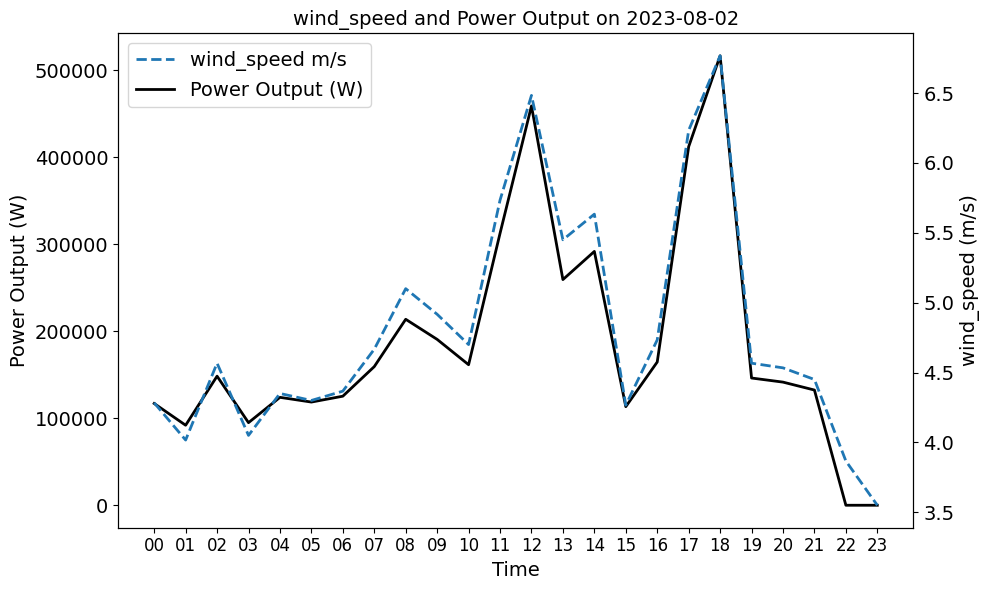

In [14]:
day = '2023-08-02'
feature='wind_speed_hub'
plot_power_and_feature(data=df,
                        features=features,
                        day=day,
                        feature=feature,
                        power=df[features['power']['name']])

Commissioning date: 2005-10-07


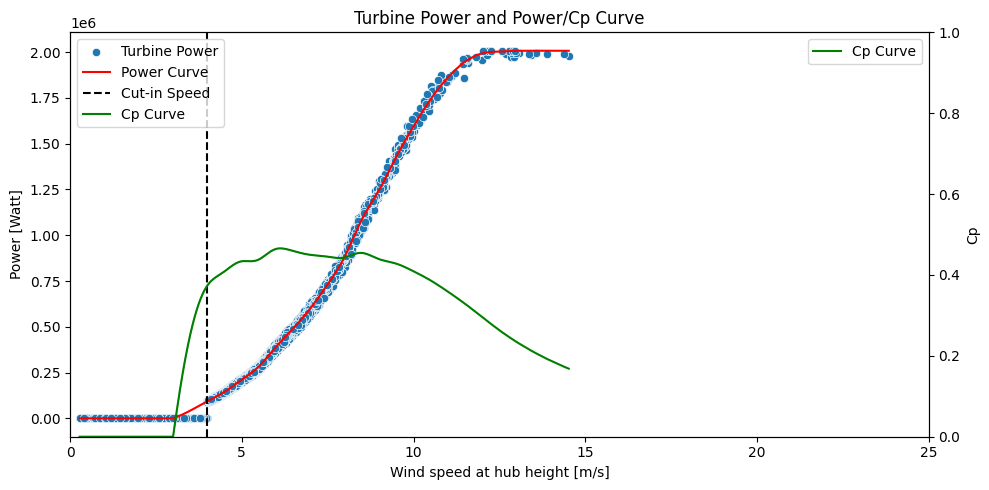

In [15]:
fig, ax1 = plt.subplots(figsize=(10, 5))

print(f'Commissioning date: {commissioning_date}')

sns.scatterplot(x=df['wind_speed_hub'], y=df['power'], label='Turbine Power', ax=ax1)
sns.lineplot(x=df['wind_speed_hub'], y=power_curve, color='red', label='Power Curve', ax=ax1)

ax1.set_xlabel('Wind speed at hub height [m/s]')
ax1.set_ylabel('Power [Watt]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
# vertical line at cut-in speed
ax1.axvline(x=cut_in, color='black', linestyle='--', label='Cut-in Speed')
ax1.set_xlim(0, 25)

ax2 = ax1.twinx()

sns.lineplot(x=df['wind_speed_hub'], y=Cp, color='green', label='Cp Curve', ax=ax2)

ax2.set_ylabel('Cp')
ax2.tick_params(axis='y')
ax2.set_ylim(0, 1)

# 5. Legenden kombinieren (optional, aber empfohlen für Übersichtlichkeit)
# Holen Sie die Handles (Linien/Punkte) und Labels von beiden Achsen
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
# Kombinieren Sie sie und zeigen Sie eine gemeinsame Legende an
# (loc='best' versucht, den besten Ort zu finden)
ax1.legend(h1 + h2, l1 + l2, loc='upper left') # Passen Sie 'loc' nach Bedarf an
plt.title('Turbine Power and Power/Cp Curve')
fig.tight_layout()
plt.show()

In [16]:
from_date = '2024-01-01'
to_date = '2024-12-31'
year_of_interest = df[from_date:to_date]
print(f'Total energy produced: {year_of_interest["power"].sum() / 1e9} GWh')

Total energy produced: 1.1508865395253234 GWh
